In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os
import pandas as pd
from tqdm import tqdm

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom
import cv2
import os
base_path =  os.path.dirname(os.getcwd())
preprocessing_path = f'{base_path}\\preprocessing'
train_images_path = f'{base_path}\\train_images\\'
weights_path = f'{base_path}\\weights\\simple_unet.onnx'
csv_path = f'{base_path}\\train_series_descriptions.csv'

image_dir = train_images_path

two_classes_category = ['L5-S1', 'L4-L5', 'L3-L4', 'L2-L3', 'L1-L2']
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x) 
    return (x * 255).astype("uint8")


def load_dicom_stack(dicom_folder: str, plane: str, reverse_sort: bool = False) -> dict:
        dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
        dicoms = [pydicom.dcmread(f) for f in dicom_files]
        plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
        positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
        # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
        # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
        idx = np.argsort(-positions if reverse_sort else positions)
        ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
        iop = np.asarray([d.ImageOrientationPatient for d in dicoms]).astype("float")[idx]
        first_dicom = pydicom.dcmread(dicom_files[0])
        target_shape = first_dicom.pixel_array.shape
        target_shape = (target_shape[1], target_shape[0])
        array = np.stack([cv2.resize(d.pixel_array.astype("float32"), target_shape) for d in dicoms])
        array = array[idx]
        sorted_files = [dicom_files[i] for i in idx]
        return {"array": convert_to_8bit(array), "positions": ipp, "orientations": iop, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float"), "sorted_files": sorted_files}





def point_to_plane_distance(point, plane_point, plane_normal):
    # Calculate the distance from the point to the plane
    point = np.array(point)
    plane_point = np.array(plane_point)
    plane_normal = np.array(plane_normal)
    
    d_plane = np.abs(np.dot(plane_normal, point - plane_point)) / np.linalg.norm(plane_normal)
    
    return d_plane

def project_point_onto_plane(point, plane_point, plane_normal):
    # Project the point onto the plane
    point = np.array(point)
    plane_point = np.array(plane_point)
    plane_normal = np.array(plane_normal)
    
    d_plane = np.dot(plane_normal, point - plane_point) / np.linalg.norm(plane_normal)**2
    projected_point = point - d_plane * plane_normal
    
    return projected_point

def point_in_square(projected_point, square_vertices):
    # Check if the projected point lies within the square
    v1 = square_vertices[1] - square_vertices[0]
    v2 = square_vertices[3] - square_vertices[0]
    
    vp = projected_point - square_vertices[0]
    
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)
    dot22 = np.dot(v2, v2)
    dot1p = np.dot(v1, vp)
    dot2p = np.dot(v2, vp)
    
    inv_denom = 1 / (dot11 * dot22 - dot12 * dot12)
    u = (dot22 * dot1p - dot12 * dot2p) * inv_denom
    v = (dot11 * dot2p - dot12 * dot1p) * inv_denom
    
    return (u >= 0) and (v >= 0) and (u <= 1) and (v <= 1)

def distance_point_to_segment(point, v1, v2):
    # Compute the distance from a point to a line segment
    v1, v2, point = np.array(v1), np.array(v2), np.array(point)
    segment_vector = v2 - v1
    point_vector = point - v1
    segment_length = np.linalg.norm(segment_vector)
    
    if segment_length == 0:
        return np.linalg.norm(point_vector)
    
    t = max(0, min(1, np.dot(point_vector, segment_vector) / (segment_length**2)))
    projection = v1 + t * segment_vector
    
    return np.linalg.norm(projection - point)

def point_to_square_distance(point, square_vertices):
    # Ensure the vertices are numpy arrays
    square_vertices = [np.array(v) for v in square_vertices]
    
    # Compute the plane normal
    v1 = square_vertices[1] - square_vertices[0]
    v2 = square_vertices[3] - square_vertices[0]
    plane_normal = np.cross(v1, v2)
    
    # Calculate the distance to the plane
    d_plane = point_to_plane_distance(point, square_vertices[0], plane_normal)
    
    # Project the point onto the plane
    projected_point = project_point_onto_plane(point, square_vertices[0], plane_normal)
    
    # Check if the projected point is within the square
    if point_in_square(projected_point, square_vertices):
        return d_plane
    
    return np.inf


def find_world_point_on_sag(sag_Oxyz, point_xyz, orient_xyz_xyz, axial_height, axial_width,
                            axial_sp_X, axial_sp_Y, sag_sp_X, sag_sp_Y):
    coord_diff = (point_xyz - sag_Oxyz)
    x_1 = np.round(coord_diff[1] / sag_sp_X).astype(int)
    y_1 = np.round(-1 * coord_diff[2] / sag_sp_Y).astype(int)

    slope_x, slope_y = orient_xyz_xyz[4:]
    slope_y = - slope_y

    new_point_coord = coord_diff + axial_height * axial_sp_Y * orient_xyz_xyz[3:]

    # this part doesn't work well
    x_2 = np.round(new_point_coord[1] / sag_sp_X).astype(int)
    y_2 = np.round(-1 * new_point_coord[2] / sag_sp_Y).astype(int)

    return x_1, y_1, x_2, y_2, slope_x, slope_y

def plot_axial(study, df_classes_axial):
    for row in study.itertuples():
        if row.series_description == "Sagittal T2/STIR":
            sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        elif row.series_description == "Sagittal T1":
            sag_t1 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        elif row.series_description == "Axial T2":
            ax_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="axial", reverse_sort=True)
    top_left_hand_corner_sag_t2 = sag_t2["positions"][len(sag_t2["array"]) // 2]

    sag_y_axis_to_pixel_space = [top_left_hand_corner_sag_t2[2]]
    while len(sag_y_axis_to_pixel_space) < sag_t2["array"].shape[1]: 
        sag_y_axis_to_pixel_space.append(sag_y_axis_to_pixel_space[-1] - sag_t2["pixel_spacing"][1])

    sag_y_coord_to_axial_slice = {}
    for ax_t2_slice, ax_t2_pos, ax_file_name in zip(ax_t2["array"], ax_t2["positions"], ax_t2["sorted_files"]):
        if df_classes_axial["class_id"].loc[df_classes_axial["path"] == ax_file_name].isin(two_classes_category).any():
            diffs = np.abs(np.asarray(sag_y_axis_to_pixel_space) - ax_t2_pos[2])
            sag_y_coord = np.argmin(diffs)
            sag_y_coord_to_axial_slice[sag_y_coord] = ax_t2_slice

    fig, ax = plt.subplots(1, 2)

    fig.set_size_inches(20, 10)

    sag_midline_slice = pydicom.dcmread(sag_t2["sorted_files"][len(sag_t2["sorted_files"]) // 2 + 1]).pixel_array
    print(sag_midline_slice.shape)
    ax[0].imshow(sag_midline_slice, cmap="gray")
    for k in [*sag_y_coord_to_axial_slice]: 
        ax[0].axhline(y=k, color="red", linestyle="--")


    sag_midline_slice = sag_t2["array"][len(sag_t2["array"]) // 2]
    print(sag_midline_slice.shape)
    ax[1].imshow(sag_midline_slice, cmap="gray")
    sag_y_coord_to_axial_slice = {}
    for i, (ax_t2_pos, ax_t2_ori, ax_t2_slice, ax_file_name) in enumerate(zip(ax_t2["positions"], ax_t2["orientations"], ax_t2["array"], ax_t2["sorted_files"])):
        if df_classes_axial["class_id"].loc[df_classes_axial["path"] == ax_file_name].isin(two_classes_category).any():
            line_ = find_world_point_on_sag(sag_t2["positions"][len(sag_t2["array"]) // 2], ax_t2_pos, ax_t2_ori, *ax_t2_slice.shape,
                                *ax_t2["pixel_spacing"], *sag_t2["pixel_spacing"])
            sag_y_coord_to_axial_slice[i] = line_

    for i, (x_1, y_1, x_2, y_2, slope_x, slope_y) in sag_y_coord_to_axial_slice.items():
        # Draw the line
        ax[1].axline((x_1, y_1), (x_2, y_2), color="blue")
        
        # Extract the corresponding file name for labeling
        file_name = df_classes_axial["path"].loc[df_classes_axial["path"] == ax_t2["sorted_files"][i]].values[0]
        
        # Add a text label near the midpoint of the line
        mid_x, mid_y = (x_1 + x_2) / 2, (y_1 + y_2) / 2
        ax[1].text(mid_x, mid_y, os.path.basename(file_name), color="red", fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))


    plt.show()






(448, 448)
(448, 448)


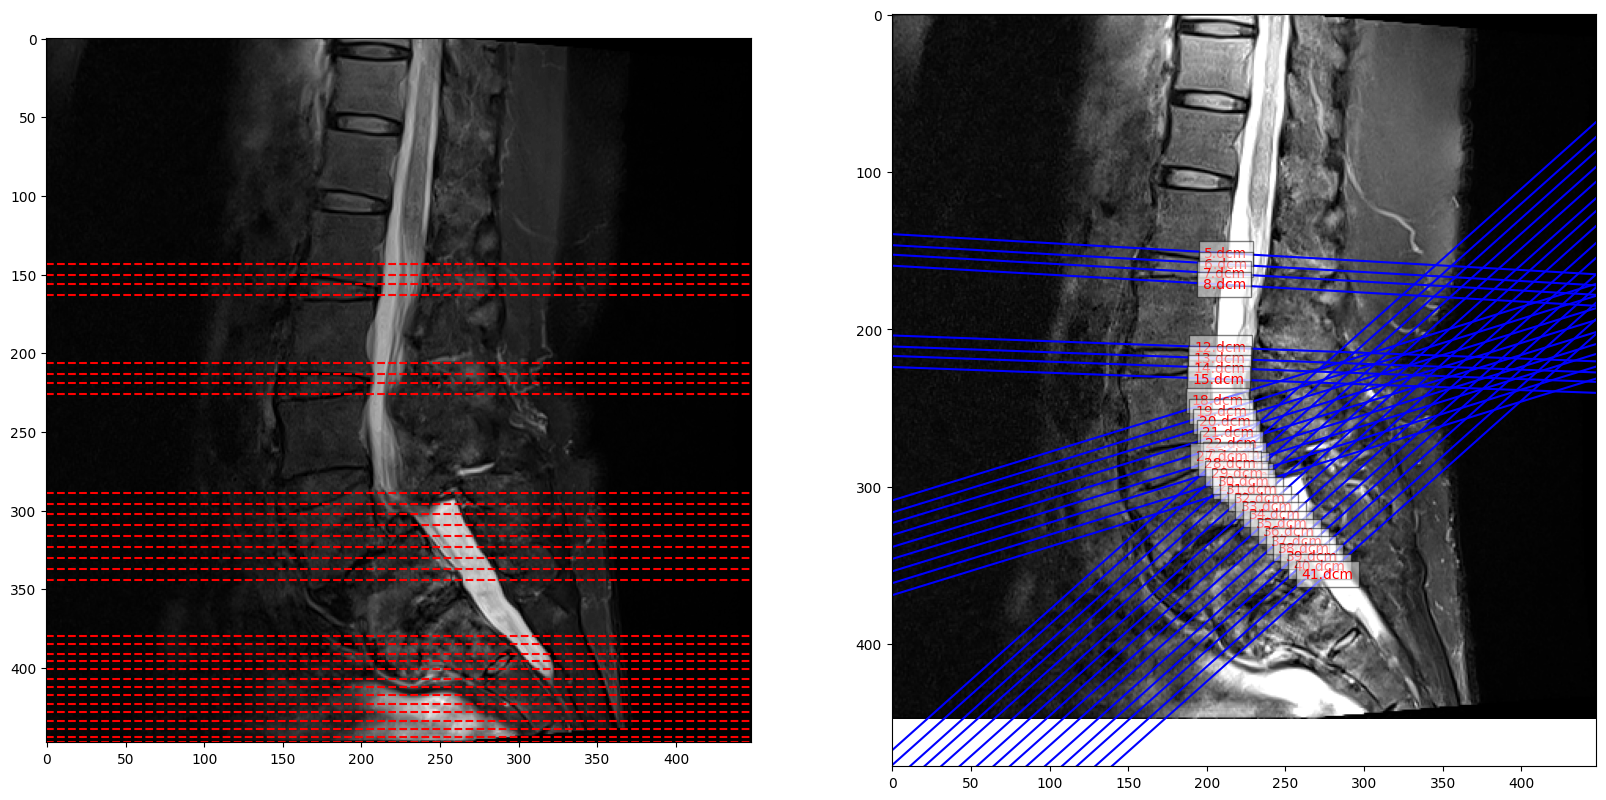

In [2]:

import pandas as pd
import sys
sys.path.insert(0, preprocessing_path)
from Cross_Reference_Axial import CrossReferenceAxial
cross_reference_axial = CrossReferenceAxial(train_images_path, weights_path)
df_description = pd.read_csv(csv_path)
study_id = 2097856420      


# for study_id in df_description.study_id:
decription_df = df_description[(df_description['study_id'] == study_id)]

df_classes_axial = cross_reference_axial.get_cross_reference_for_Axial(decription_df, "test")
study = df_description.loc[df_description.study_id == study_id]
plot_axial(study, df_classes_axial)


In [3]:
df_classes_axial["path"] = df_classes_axial["path"].apply(lambda x: x.split("\\")[-1])

In [4]:
df_classes_axial

,path,class_id
0,5.dcm,L2-L3
1,6.dcm,L2-L3
2,7.dcm,L2-L3
3,8.dcm,L2-L3
4,12.dcm,L3-L4
5,13.dcm,L3-L4
6,14.dcm,L3-L4
7,15.dcm,L3-L4
8,18.dcm,L4-L5
9,19.dcm,L4-L5


In [5]:
list_ = [1,2,3,4,5]
list_ = list_[-20:]
list_

[1, 2, 3, 4, 5]